# CH13: Parallelizing Neural Network Training with TensorFlow

https://www.tensorflow.org/

In [1]:
import tensorflow as tf
import tensorflow.contrib.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, Image, display, HTML

In [2]:
tf.__version__

'1.9.0'

## First steps with TensorFlow

In [3]:
g = tf.Graph()

In [4]:
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=None, name="x")
    w = tf.Variable(2.0, name="weight")
    b = tf.Variable(0.7, name="bias")
    
    z = w*x + b
    
    init = tf.global_variables_initializer()

In [5]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    
    for t in [1.0, 0.6, -1.8]:
        print("x=%4.1f --> z=%4.1f" % (t, sess.run(z, feed_dict={x: t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


## Working with array structures

In [6]:
g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name="input_x")
    
    x2 = tf.reshape(x, shape=(-1, 6), name="x2")
    xsum = tf.reduce_sum(x2, axis=0, name="col_sum")
    xmean = tf.reduce_mean(x2, axis=0, name="col_mean")

In [7]:
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    
    print("input shape: ", x_array.shape)
    print("input array:\n", x_array)
    print("resphaed: \n", sess.run(x2, feed_dict={x: x_array}))
    print("column sums:\n ", sess.run(xsum, feed_dict={x: x_array}))
    print("row sums:\n ", sess.run(xmean, feed_dict={x: x_array}))

input shape:  (3, 2, 3)
input array:
 [[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
resphaed: 
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
column sums:
  [18. 21. 24. 27. 30. 33.]
row sums:
  [ 6.  7.  8.  9. 10. 11.]


## Developing a simple model with the low-level TensorFlow API

Ordinary Least Squares (OLS) regression

In [8]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [9]:
class TfLinreg:
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.x_dim), name="x_input")
        self.y = tf.placeholder(dtype=tf.float32, name="y_input")
        
        print(self.X)
        print(self.y)
        
        w = tf.Variable(tf.zeros(shape=(1)), name="weight")
        b = tf.Variable(tf.zeros(shape=(1)), name="bias")
        
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w*self.X + b, name="z_net")
        
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net, name="sq_errors")
        
        print(sqr_errors)
        
        self.mean_cost = tf.reduce_mean(sqr_errors, name="mean_cost")
        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate = self.learning_rate,
            name = "GradientDescent"
        )
        self.optimizer = optimizer.minimize(self.mean_cost)
        
    def train(self, sess, X_train, y_train, num_epochs=10):
        sess.run(self.init_op)
        
        training_costs = []
        for i in range(num_epochs):
            _, cost = sess.run(
                [self.optimizer, self.mean_cost], 
                feed_dict={
                    self.X: X_train,
                    self.y: y_train
                }
            )
            training_costs.append(cost)
        
        return training_costs
    
    def predict(self, sess, X):
        y_pred = sess.run(self.z_net, feed_dict={self.X: X})
        return y_pred

In [10]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

with tf.Session(graph=lrmodel.g) as sess:
    writer = tf.summary.FileWriter(".", sess.graph)
    training_costs = lrmodel.train(sess, X_train, y_train)
    writer.close()

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sq_errors:0", dtype=float32)


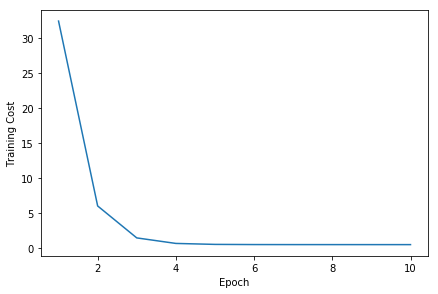

In [11]:
plt.plot(range(1, len(training_costs)+1), training_costs)
plt.tight_layout()
plt.xlabel("Epoch")
plt.ylabel("Training Cost")
plt.show()

RuntimeError: Attempted to use a closed Session.

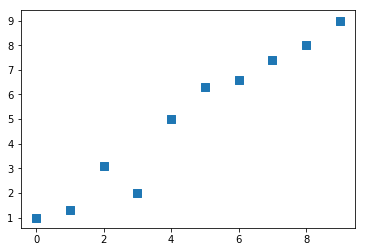

In [13]:
plt.scatter(X_train, y_train, marker="s", s=50, label="Training Data")
plt.plot(
    range(X_train.shape[0]), lrmodel.predict(sess, X_train), 
    color="gray", marker="o", markersize=6, linewidth=3, label="Linear Model"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## Training neural networks efficiently with high-level TensorFlow APIs

In [14]:
from tensorflow.examples.tutorials.mnist import input_data

In [15]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [16]:
X_train = mnist.train.images
y_train = mnist.train.labels

In [17]:
X_test = mnist.test.images
y_test = mnist.test.labels

### Building multilayer neural networks using TensorFlow's Layers API

In [18]:
n_features = X_train.shape[1]
n_classes = 10

random_seed = 123
np.random.seed(random_seed)

In [19]:
g = tf.Graph()

with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="tf_x")
    tf_y = tf.placeholder(dtype=tf.int32, shape=None, name="tf_y")
    
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    
    h1 = tf.layers.dense(inputs=tf_x, units=50, activation=tf.tanh, name="layer1")
    h2 = tf.layers.dense(inputs=h1, units=50, activation=tf.tanh, name="layer2")
    logits = tf.layers.dense(inputs=h2, units=10, activation=None, name="layer3")
    
    predictions = {
        "classes": tf.argmax(logits, axis=1, name="predicted_classes"),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }


In [20]:
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot, logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()

In [21]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [22]:
sess = tf.Session(graph=g)
sess.run(init_op)

In [23]:
for epoch in range(50):
    training_costs = []
    batch_generator = create_batch_generator(X_train, y_train, batch_size=64)
    for bX, by in batch_generator:
        feed = {tf_x: bX, tf_y: by}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print(" -- Epoch %d: %.4f" % (epoch+1, np.mean(training_costs)))

 -- Epoch 1: 1.9885
 -- Epoch 2: 1.4137
 -- Epoch 3: 1.1155
 -- Epoch 4: 0.9412
 -- Epoch 5: 0.8258
 -- Epoch 6: 0.7429
 -- Epoch 7: 0.6802
 -- Epoch 8: 0.6311
 -- Epoch 9: 0.5916
 -- Epoch 10: 0.5591
 -- Epoch 11: 0.5319
 -- Epoch 12: 0.5089
 -- Epoch 13: 0.4891
 -- Epoch 14: 0.4718
 -- Epoch 15: 0.4568
 -- Epoch 16: 0.4434
 -- Epoch 17: 0.4315
 -- Epoch 18: 0.4209
 -- Epoch 19: 0.4112
 -- Epoch 20: 0.4024
 -- Epoch 21: 0.3944
 -- Epoch 22: 0.3871
 -- Epoch 23: 0.3803
 -- Epoch 24: 0.3740
 -- Epoch 25: 0.3681
 -- Epoch 26: 0.3626
 -- Epoch 27: 0.3575
 -- Epoch 28: 0.3527
 -- Epoch 29: 0.3481
 -- Epoch 30: 0.3438
 -- Epoch 31: 0.3397
 -- Epoch 32: 0.3359
 -- Epoch 33: 0.3322
 -- Epoch 34: 0.3287
 -- Epoch 35: 0.3253
 -- Epoch 36: 0.3221
 -- Epoch 37: 0.3190
 -- Epoch 38: 0.3160
 -- Epoch 39: 0.3131
 -- Epoch 40: 0.3104
 -- Epoch 41: 0.3077
 -- Epoch 42: 0.3051
 -- Epoch 43: 0.3026
 -- Epoch 44: 0.3002
 -- Epoch 45: 0.2979
 -- Epoch 46: 0.2956
 -- Epoch 47: 0.2934
 -- Epoch 48: 0.2912
 

In [24]:
feed = {tf_x: X_test}
y_pred = sess.run(predictions["classes"], feed_dict=feed)

In [25]:
print("Test accuracy: %.2f%%" % (100*np.sum(y_pred == y_test)/y_test.shape[0]))

Test accuracy: 92.24%


## Developing a multilayer neurla network with Keras

In [26]:
from tensorflow.examples.tutorials.mnist import input_data

In [27]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

X_train = mnist.train.images
y_train = mnist.train.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
np.random.seed(123)
tf.set_random_seed(123)

In [ ]:
y_train_onehot = keras.utils.to_categorical(y_train)

In [ ]:
y_train_onehot[:3]

In [ ]:
model = keras.models.Sequential()

In [ ]:
model.add(
    keras.layers.Dense(
        units=50, input_dim=X_train.shape[1],
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="tanh"
    )
)

In [ ]:
model.add(
    keras.layers.Dense(
        units=50,
        input_dim=50, 
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="tanh"
    )
)

In [ ]:
model.add(
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="softmax"
    )
)

In [ ]:
sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=0.9)

In [ ]:
model.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy")

In [ ]:
history = model.fit(X_train, y_train_onehot, batch_size=64, epochs=50, verbose=1, validation_split=0.1)

In [ ]:
y_train_pred = model.predict_classes(X_train, verbose=0)
y_test_pred = model.predict_classes(X_test, verbose=0)

In [ ]:
def calc_accuracy(y, yhat):
    correct_preds = np.sum(y == yhat, axis=0)
    return correct_preds/y.shape[0]

In [ ]:
calc_accuracy(y_train, y_train_pred)

In [ ]:
calc_accuracy(y_test, y_test_pred)